In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta, date
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [23]:
df = pd.read_csv("/content/traffic.csv")
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [24]:
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [30]:
# Display the columns of your DataFrame
print(df.columns)

# Alternatively, you can visually inspect your DataFrame to find the datetime column
print(df.head())






Index(['DateTime', 'Junction', 'Vehicles', 'ID'], dtype='object')
              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041


In [32]:
df.drop('ID', axis=1, inplace=True)

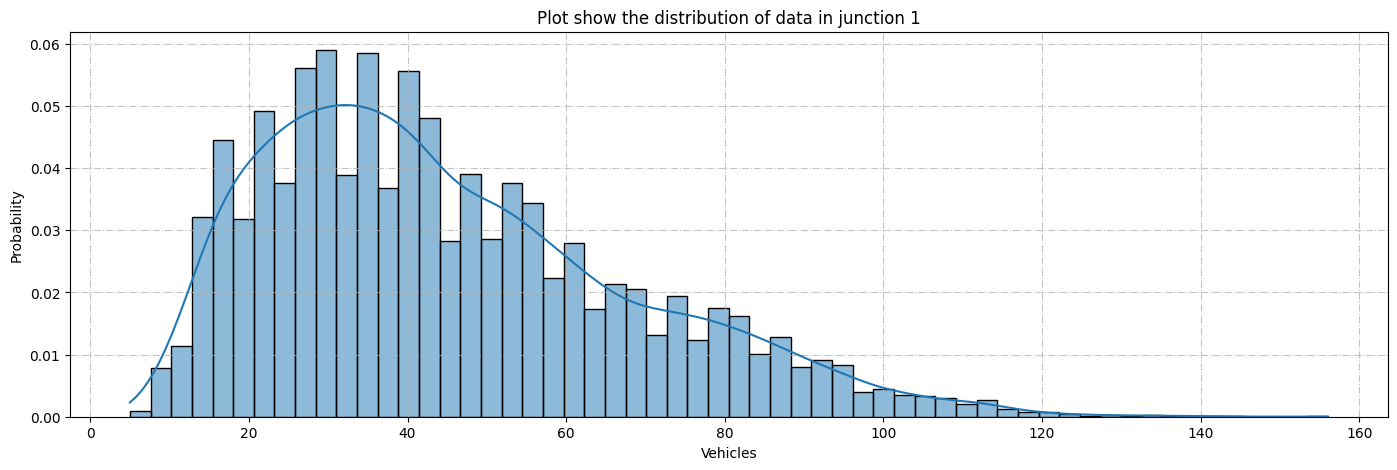

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

def make_hist(junction=1):
    data = df[df['Junction'] == junction]
    f, ax = plt.subplots(figsize=(17, 5))
    ax = sns.histplot(data['Vehicles'], kde=True, stat='probability')
    ax.set_title(f'Plot show the distribution of data in junction {junction}')
    ax.grid(True, ls='-.', alpha=0.75)
    plt.show()


make_hist(1)

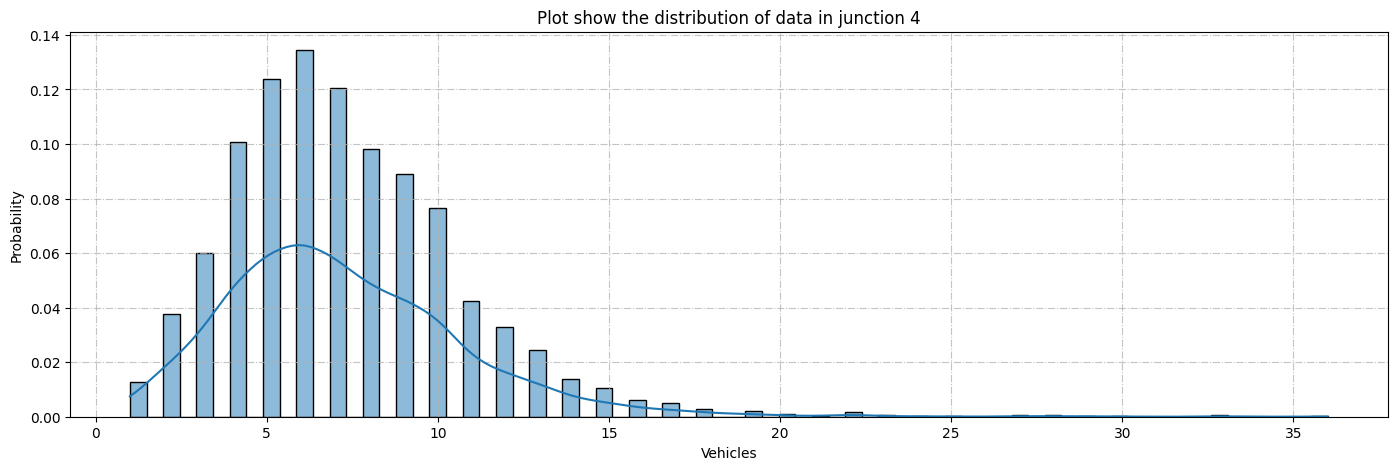

In [34]:
make_hist(4)

In [37]:
def make_time_series_plot(junction=1):
    f, ax = plt.subplots(figsize=(17, 5))
    data=df[df.Junction == junction]
    ax = sns.lineplot(data=data, y='Vehicles', x='DateTime', ax=ax)
    start = data.head(1)
    end = data.tail(1)
    ax.set_title(f'Plot show amounts of Vehicles in junction {junction} from {start.date[0]}-{start.time[0]} to {end.date[0]}-{end.time[0]}', fontsize=15)
    ax.grid(True, ls='-.', alpha=0.75)
    plt.show()

AttributeError: 'DataFrame' object has no attribute 'date'

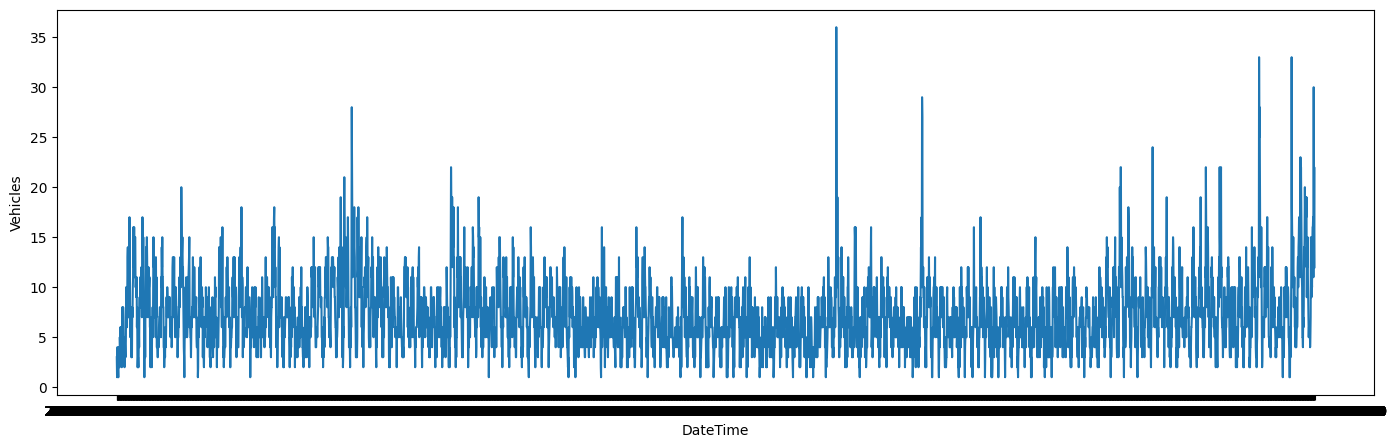

In [41]:
make_time_series_plot(4)


In [42]:
standardization = lambda x: StandardScaler().fit_transform(x)

In [43]:
z_df = df.copy()
z_df['Vehicles'] = standardization(z_df.Vehicles.values.reshape(-1, 1))
z_df.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,-0.375489
1,2015-11-01 01:00:00,1,-0.471875
2,2015-11-01 02:00:00,1,-0.616454
3,2015-11-01 03:00:00,1,-0.761034
4,2015-11-01 04:00:00,1,-0.664648


In [51]:
def get_list_data(dataf, drop=[]):
  for i in drop:
    try:
      dataf.drop(drop, axis=1, inplace=True)
    except:
      print(f"{i} doesn't has in data")
  # create a list of dataframe has the data in that junction and remove the junction identify
  dataf = [dataf[dataf.Junction == i].drop('Junction', axis=1) for i in range(5)]
  return dataf

data = get_list_data(df)
for i in data:
    print(i.head(1))

Empty DataFrame
Columns: [DateTime, Vehicles]
Index: []
              DateTime  Vehicles
0  2015-11-01 00:00:00        15
                  DateTime  Vehicles
14592  2015-11-01 00:00:00         6
                  DateTime  Vehicles
29184  2015-11-01 00:00:00         9
                  DateTime  Vehicles
43776  2017-01-01 00:00:00         3


In [52]:
def make_metrics(models):
    data = {
        'name': [model.name for model in models[1:]],
        'r2': [model.r2 for model in models[1:]],
        'rmse': [model.rmse for model in models[1:]]
    }
    data['name'] = 'average R2 and sum RMSE'
    data['r2'].append(np.mean(data['r2']))
    data['rmse'].append(np.sum(data['rmse']))
    return pd.DataFrame(data)

In [53]:
class Model:
  def __init__(self, name, data, predict_features, test_size, ml_model):
    self.name = name
    self.data = data
    self.predict_features = predict_features
    self.is_trained = False
    self.test_size = test_size
    self.ml_model = ml_model
    self.do_things()

  def cal_rmse(self):
    self.rmse = mean_squared_error(self.ytest, self.ypredict, squared=False)
    return self.rmse

  def prequisite(self, test_size):
    self.features = [i for i in self.data.columns if i != self.predict_features]
    self.X = self.data[self.features].values
    self.y = self.data[self.predict_features].values
    self.Xtrain, self.Xtest, self.ytrain, self.ytest = train_test_split(self.X, self.y, test_size=test_size)
    return None

  def fit(self):
    self.is_trained = True
    self.ml_model.fit(self.Xtrain, self.ytrain)
    self.ypredict = self.ml_model.predict(self.Xtest)
    return self.ml_model

  def cal_r2_score(self):
    self.r2 = r2_score(self.ytest, self.ypredict)
    return self.r2

  def do_things(self) -> None:
    self.prequisite(self.test_size)
    self.fit()
    self.cal_rmse()
    self.cal_r2_score()
    return None

  def feature_importances(self, ax) -> None:
    feature_importances = self.ml_model.feature_importances_
    index = lag_models[1].features
    data = pd.DataFrame(pd.Series(feature_importances, index=index).nlargest(10)).reset_index()
    data.columns = ['Features', 'Value']
    g = sns.barplot(data=data, x='Features', y='Value', ax=ax)
    for p in g.patches:
        ax.annotate(
            format(p.get_height(), '.2f'),
            (p.get_x() + p.get_width() / 2, p.get_height() + 0.02),
            ha='center', va='center', weight='bold', fontsize=9
        )
    ax.set_title(f'Plot of {self.name}', fontsize=12)
    ax.grid(True, ls='-.', alpha=0.7)
    ax.set_ylim(0, 1)

  def __repr__(self) -> str:
    if not self.is_trained:
      return f'<{self.name}> (is not trained yet)>'
    return f'<({self.name}: [R² Score: {self.r2}], [RMSE: {self.rmse}])>'


In [60]:
class Model:
  def __init__(self, name, data, predict_features, test_size, ml_model):
    self.name = name
    self.data = data
    self.predict_features = predict_features
    self.is_trained = False
    self.test_size = test_size
    self.ml_model = ml_model
    # Convert datetime features to numerical representation before doing anything else
    self.convert_datetime_features() # New method to handle datetime columns
    self.do_things()

  # ... (rest of the class methods remain unchanged)

  def convert_datetime_features(self):
    # Identify datetime columns
    datetime_cols = self.data.select_dtypes(include=['datetime']).columns

    # Convert datetime features to numerical representation (e.g., Unix timestamp)
    for col in datetime_cols:
      self.data[col] = (self.data[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')


In [64]:
class Model:
    def __init__(self, ml_model, name, data, predict_features, test_size):
        self.ml_model = ml_model
        self.name = name
        self.data = data
        self.predict_features = predict_features
        self.test_size = test_size
        self.r2 = None  # Initialize the r2 attribute

    def train_model(self):
        # Add code to train the machine learning model here
        pass

    def predict(self):
        # Add code to make predictions using the trained model
        pass

    def evaluate(self):
        # Add code to evaluate the model performance
        pass

    def do_things(self):
        # Add any additional methods or functionality here
        pass



In [65]:
lag_df = df.copy()
for i in range(1, 3):
    lag_df[f'Vehicles_lag_{i}'] = df.Vehicles.shift(i)

# drop all rows with nan, because lag data cause nan
lag_df.dropna(inplace=True)
lag_df.head()

,DateTime,Junction,Vehicles,Vehicles_lag_1,Vehicles_lag_2
2,2015-11-01 02:00:00,1,10,13.0,15.0
3,2015-11-01 03:00:00,1,7,10.0,13.0
4,2015-11-01 04:00:00,1,9,7.0,10.0
5,2015-11-01 05:00:00,1,6,9.0,7.0
6,2015-11-01 06:00:00,1,9,6.0,9.0


In [66]:
lag_data = get_list_data(lag_df, drop=['Year'])
for i in lag_data:
    print(i.head(1))

Year doesn't has in data
Empty DataFrame
Columns: [DateTime, Vehicles, Vehicles_lag_1, Vehicles_lag_2]
Index: []
              DateTime  Vehicles  Vehicles_lag_1  Vehicles_lag_2
2  2015-11-01 02:00:00        10            13.0            15.0
                  DateTime  Vehicles  Vehicles_lag_1  Vehicles_lag_2
14592  2015-11-01 00:00:00         6            78.0            84.0
                  DateTime  Vehicles  Vehicles_lag_1  Vehicles_lag_2
29184  2015-11-01 00:00:00         9            27.0            29.0
                  DateTime  Vehicles  Vehicles_lag_1  Vehicles_lag_2
43776  2017-01-01 00:00:00         3            39.0            26.0
